In [3]:
import numpy as np
import torch
from torch import nn
import hypnettorch

In [11]:
from hypnettorch.data import FashionMNISTData, MNISTData 

mnist = MNISTData('./datasets', use_one_hot=True, validation_size=0)
fmnist = FashionMNISTData('./datasets', use_one_hot=True, validation_size=0)

# Get a batch of training samples from each data handler.
mnist_inps, mnist_trgts = mnist.next_train_batch(4)
fmnist_inps, fmnist_trgts = fmnist.next_train_batch(4)

Reading MNIST dataset ...
Elapsed time to read dataset: 0.537000 sec


# Instantiating the target models

In [19]:
from hypnettorch.mnets import MLP

num_pixel = np.prod(mnist.in_shape)

# Create a fully-connected network with and without internal parameters.
mlp_with = MLP(n_in=num_pixel, n_out=10, hidden_layers=[400,400],
               no_weights=False)

mlp_without = MLP(n_in=num_pixel, n_out=10, hidden_layers=[400,400],
                  no_weights=True)

Creating an MLP with 478410 weights.
Creating an MLP with 478410 weights.


In [20]:
from hypnettorch.mnets import LeNet

mnet = LeNet(in_shape=mnist.in_shape, num_classes=mnist.num_classes,
             arch='mnist_small', no_weights=True)

Creating a LeNet with 21840 weights.


# Instantiating the Hypernetwork

In [21]:
from hypnettorch.hnets import HMLP

hnet = HMLP(mnet.param_shapes, uncond_in_size=0, cond_in_size=8,
            layers=[100, 100], num_cond_embs=2)

print()
print('The randomly initialized input embeddings are:\n', 
      hnet.conditional_params)

# To produce main network weights for condition `0`, we can either pass
# the corresponding condition ID, or the corresponding (internally maintained)
# embedding to the `forward` of the hypernetwork.
W0 = hnet.forward(cond_id=0)
W0_tmp = hnet.forward(cond_input=hnet.conditional_params[0].view(1, -1))
assert np.all([torch.equal(W0[i], W0_tmp[i]) for i in range(len(W0))])

# Hypernetworks also allow batch processing.
W_batch = hnet.forward(cond_id=[0, 0])
assert np.all([torch.equal(W_batch[0][i], W_batch[1][i]) \
               for i in range(len(W0))])

Created MLP Hypernet.
Hypernetwork with 2216856 weights and 21840 outputs (compression ratio: 101.50).
The network consists of 2216840 unconditional weights (2216840 internally maintained) and 16 conditional weights (16 internally maintained).

The randomly initialized input embeddings are:
 [Parameter containing:
tensor([ 0.5445, -0.8637, -0.9116,  1.6963, -1.3447, -0.8855,  0.8467,  0.7049],
       requires_grad=True), Parameter containing:
tensor([-0.3763, -0.9515,  0.9539, -0.1075, -0.4839,  1.1493, -0.4073, -0.4692],
       requires_grad=True)]


In [22]:
hnet.apply_hyperfan_init(mnet=mnet)

In [24]:
# Get a batch of main network inputs.
mnist_inps, _ = mnist.next_train_batch(4)
X = mnist.input_to_torch_tensor(mnist_inps, 'cpu', mode='train')

# Generate the main network weights for both conditions.
W = hnet.forward(cond_id=[0, 1])

Y0 = mnet.forward(X, weights=W[0])
print('Predicted classes for condition 0: ', Y0.max(dim=1)[1])

Y1 = mnet.forward(X, weights=W[1])
print('Predicted classes for condition 1: ', Y1.max(dim=1)[1])

Predicted classes for condition 0:  tensor([7, 7, 7, 7])
Predicted classes for condition 1:  tensor([8, 8, 8, 8])


In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def calc_accuracy(data, mnet, mnet_weights):
    """Compute the test accuracy for a given dataset"""
    with torch.no_grad():
        # Process complete test set as one batch.
        test_in = data.input_to_torch_tensor( \
            data.get_test_inputs(), device, mode='inference')
        test_out = data.input_to_torch_tensor( \
            data.get_test_outputs(), device, mode='inference')
        test_lbls = test_out.max(dim=1)[1]

        logits = mnet(test_in, weights=mnet_weights)
        pred_lbls = logits.max(dim=1)[1]

        acc = torch.sum(test_lbls == pred_lbls) / test_lbls.numel() * 100.

    return acc

# Configure training.
lr=1e-4
batchsize=32
nepochs=10

# Adam usually works well in combination with hypernetwork training.
optimizer = torch.optim.Adam(hnet.internal_params, lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(nepochs): # For each epoch.

    # Iterate over the whole MNIST/FashionMNIST training set.
    # Note, that both datasets have the same number of training samples.
    i = 0
    for curr_batchsize, mx, my in mnist.train_iterator(batchsize):
        i += 1

        # Current mini-batch of MNIST samples.
        mnist_X = mnist.input_to_torch_tensor(mx, device, mode='train')
        mnist_Y = mnist.output_to_torch_tensor(my, device, mode='train')
        
        # Current mini-batch of FashionMNIST samples.
        fx, fy = fmnist.next_train_batch(curr_batchsize)
        fmnist_X = fmnist.input_to_torch_tensor(fx, device, mode='train')
        fmnist_Y = fmnist.output_to_torch_tensor(fy, device, mode='train')

        optimizer.zero_grad()

        # Compute MNIST loss.
        W_mnist = hnet(cond_id=0)
        mnist_P = mnet.forward(mnist_X, weights=W_mnist)
        loss_mnist = criterion(mnist_P, mnist_Y.max(dim=1)[1])
        
        # Compute FashionMNIST loss.
        W_fmnist = hnet(cond_id=1)
        fmnist_P = mnet.forward(fmnist_X, weights=W_fmnist)
        loss_fmnist = criterion(fmnist_P, fmnist_Y.max(dim=1)[1])
        
        # The total loss is simply each task's loss combined.
        loss = loss_mnist + loss_fmnist
        loss.backward()
        optimizer.step()

        if i % 500 == 0:            
            print('[%d, %5d] loss: %.3f, MNIST acc: %.2f%%, FashionMNIST acc: %.2f%%' %
                  (epoch + 1, i + 1, loss.item(), 
                   calc_accuracy(mnist, mnet, W_mnist),
                   calc_accuracy(fmnist, mnet, W_fmnist)))


print('Training finished with test-accs: MNIST acc: %.2f%%, FashionMNIST %.2f%%' % \
      (calc_accuracy(mnist, mnet, W_mnist),
       calc_accuracy(fmnist, mnet, W_fmnist)))

[1,   501] loss: 0.331, MNIST acc: 97.14%, FashionMNIST acc: 76.17%
[1,  1001] loss: 0.679, MNIST acc: 97.89%, FashionMNIST acc: 82.56%
[1,  1501] loss: 0.616, MNIST acc: 97.70%, FashionMNIST acc: 84.70%
[2,   501] loss: 0.712, MNIST acc: 98.17%, FashionMNIST acc: 85.37%
[2,  1001] loss: 0.673, MNIST acc: 98.25%, FashionMNIST acc: 86.60%
[2,  1501] loss: 0.215, MNIST acc: 98.22%, FashionMNIST acc: 85.38%
[3,   501] loss: 0.520, MNIST acc: 98.70%, FashionMNIST acc: 86.51%
[3,  1001] loss: 0.269, MNIST acc: 98.53%, FashionMNIST acc: 86.35%
[3,  1501] loss: 0.406, MNIST acc: 98.70%, FashionMNIST acc: 86.94%
[4,   501] loss: 0.708, MNIST acc: 98.78%, FashionMNIST acc: 87.49%
[4,  1001] loss: 0.385, MNIST acc: 98.58%, FashionMNIST acc: 87.95%
[4,  1501] loss: 0.433, MNIST acc: 98.78%, FashionMNIST acc: 88.18%
[5,   501] loss: 0.389, MNIST acc: 98.44%, FashionMNIST acc: 88.22%
[5,  1001] loss: 0.228, MNIST acc: 98.57%, FashionMNIST acc: 87.12%
[5,  1501] loss: 0.259, MNIST acc: 98.65%, Fashi

In [34]:
# Get a batch of test samples from each data handler.
mnist_inps, mnist_trgts = mnist.next_test_batch(4)
fmnist_inps, fmnist_trgts = fmnist.next_test_batch(4)

# Compute predictions for test batches above.
with torch.no_grad():
    mnist_X = mnist.input_to_torch_tensor(mnist_inps, device, mode='inference')
    fmnist_X = mnist.input_to_torch_tensor(fmnist_inps, device, mode='inference')
    
    W_mnist = hnet(cond_id=0)
    mnist_preds = mnet.forward(mnist_X, weights=W_mnist)

    W_fmnist = hnet(cond_id=1)
    fmnist_preds = mnet.forward(fmnist_X, weights=W_fmnist)
    
    # Note, the network outputs are logits, and thus not normalized.
    mnist_preds = torch.softmax(mnist_preds, dim=1)
    fmnist_preds = torch.softmax(fmnist_preds, dim=1)
    
    mnist_preds = mnist_preds.detach().cpu().numpy()
    fmnist_preds = fmnist_preds.detach().cpu().numpy()



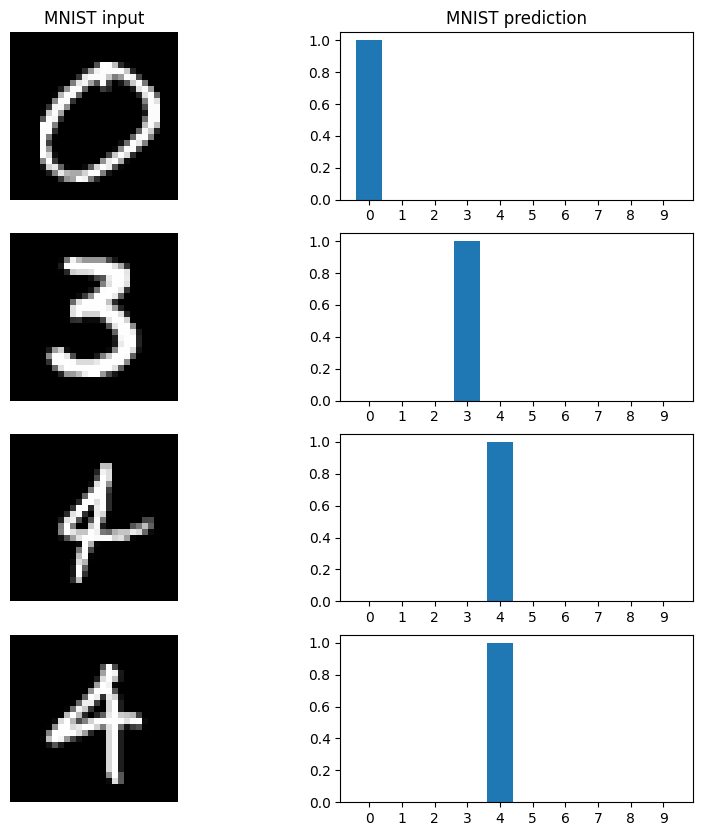

In [35]:
# Plot the predictions for first 10 MNIST inputs.
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
axs[0, 0].set_title('MNIST input')
axs[0, 1].set_title('MNIST prediction')
for i in range(4):
    axs[i, 0].imshow(mnist_inps[i].reshape(28, 28), cmap='gray')
    # axs[i, 0].set_title('MNIST input')
    axs[i, 0].axis('off')
    axs[i, 1].bar(np.arange(10), mnist_preds[i])
    # axs[i, 1].set_title('MNIST prediction')
    axs[i, 1].set_xticks(np.arange(10))
    axs[i, 1].set_xticklabels(np.arange(10))


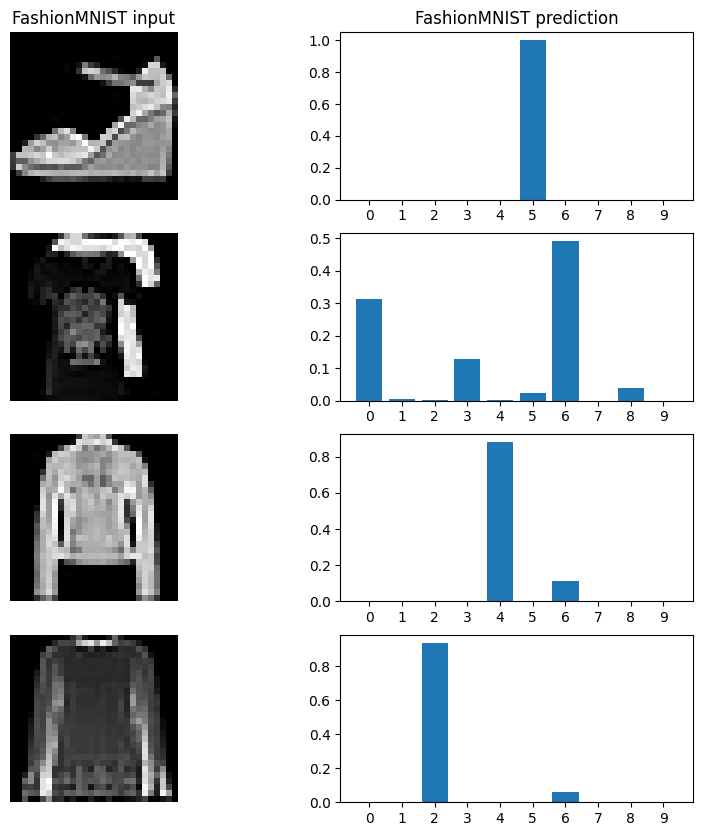

In [36]:
# Plot the predictions for first 10 FashionMNIST inputs.
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
axs[0, 0].set_title('FashionMNIST input')
axs[0, 1].set_title('FashionMNIST prediction')
for i in range(4):
    axs[i, 0].imshow(fmnist_inps[i].reshape(28, 28), cmap='gray')
    # axs[i, 0].set_title('FashionMNIST input')
    axs[i, 0].axis('off')
    axs[i, 1].bar(np.arange(10), fmnist_preds[i])
    # axs[i, 1].set_title('FashionMNIST prediction')
    axs[i, 1].set_xticks(np.arange(10))
    axs[i, 1].set_xticklabels(np.arange(10))

In [37]:
print(num_pixel)

784
